# Projeto D3-TOP

## 1. Descrição do problema

Em 2022 o Superior Tribunal de Justiça (STJ) passou a disponibilizar os dados de processos judiciais que tramitam naquela corte em um portal de dados abertos ([Notícia de 20/05/2022](https://www.stj.jus.br/sites/portalp/Paginas/Comunicacao/Noticias/20052022-Novo-Portal-de-Dados-Abertos-amplia-transparencia-de-acoes-realizadas-no-STJ.aspx)). Esse novo portal passou a disponibilizar dados que já estavam disponíveis publicamente na página web do STJ de maneira estruturada e acessível por máquina, sem a necessidade de realizar *web scraping*.

Dos dados disponíveis, existe um conjunto denominado "Íntegras de Decisões Terminativas e Acórdãos do Diário da Justiça". Neste repositório estão disponíveis decisões que terminam processos, seja indeferindo recursos à corte ou dando-lhes provimento monocraticamente, seja acórdãos de casos específicos.

Atualmente são disponibilizados como metadados vários elementos dos processos, como tipo, teor (Negando, Dando provimento, etc), assuntos vinculados, etc. Essas informações facilitam a busca e filtragem de dados no dataset. Essas informações são cadastradas manualmente pelos operadores do direito, sejam os advogados das partes, sejam os serventuários da justiça, e dependem da entrada manual dos dados.

O problema que se busca analisar e eventualmente solucionar com esse projeto é a utilização de técnicas de Processamento de Linguagem natural (*Natural Language Processing* - NLP) para verificar se é possível e com que exatidão prever os assuntos abordados nas decisões sem depender da interação humana.


## 2. Descrição da base de dados

Para esse projeto será utilizada a base de dados abertos do STJ, especificamente a base "*Íntegras de Decisões Terminativas e Acórdãos do Diário da Justiça*", disponível em https://dadosabertos.web.stj.jus.br/dataset/integras-de-decisoes-terminativas-e-acordaos-do-diario-da-justica.

A base de dados possui um dicionário (dicionariointegrasdecisoes.csv) com a descrição dos campos e seus tipos associados.

Nessa base de dados é disponibilizado, nos dias que existe publicação no diário oficial, um arquivo .zip. Referido arquivo possui um arquivos denominado metadados, em json, descrevendo:


| Campo | Tipo | Descrição |
|---|---|---|
| SeqDocumento | Numérico | Identificador da decisão ou acórdão. Corresponde ao nome do arquivo TXT encontrado no ZIP, no qual consta o texto completo da decisão ou acórdão. |
| dataPublicacao | Data | Data da publicação do documento no Diário da Justiça Eletrônico. | 
| tipoDocumento | Texto | Informa se o documento é um acórdão ou uma decisão terminativa. |  
| numeroRegistro | Texto| Numero de registro do processo no qual foi proferido o Acórdão ou Decisão no Sistema do STJ |  
| processo | Texto | Sigla da classe processual seguida do número do processo naquela classe. |
| dataRecebimento | Data | Data que o processo foi recebido no STJ. |
| dataDistribuição | Data | Data que o processo foi distribuído. |
| ministro | Texto | Nome do ministro relator do acórdão ou proferidor da decisão. |
| recurso | Texto | Indica o recurso interno sobre o qual foi proferida a decisão ou acórdão se houver. Quando nulo, indica que se refere ao processo principal. |
| teor | Texto |Pequeno texto que corresponde ao desfecho do julgamento. Ex. Concedendo, Denegando, Não Conhecendo etc. Disponível para acórdãos e decisões monocráticas. |
| descricaoMonocratica | Texto | Pequeno texto que corresponde à conclusão do julgado. Disponível apenas para decisões monocráticas. |
| assuntos | Texto | Lista dos códigos CNJ dos assuntos relacionados ao processo separados por ';'.  O significado desses códigos estão disponíveis para download em ottps://dpj.cnj.jus.br/sgt/api/v1.0/assuntos.csv e para https://www.cnj.jus.br/sgt/consulta_publica_assuntos.php. |

O identificador do documento é utilizado para identificar o arquivo .txt dentro do diretório compactado que contém o texto da decisão.

## 3. Objetivo científico associado ao problema

A utilização de técnicas de NLP tem objetivos científicos, especificamente: **a)** verificar o quanto os sistemas de NLP são capazes de realizar a classificação de textos jurídicos automaticamente, utilizando os dados já rotulados e **b)** Partir de classificações mais genéricas para mais específicas e, eventualmente, classificar as decisões em critérios mais específicos que os disponíveis atualmente.

## 4. Obtenção dos dados

### 4.1 Download dos dados em si
Os dados estão disponíveis no repositório de dados públicos do STJ pela API comum da CKAN. Inicialmente precisamos fazer o download dos dados.

In [1]:
#!pip install feather-format
#!pip install prettyprint
#!pip install nltk

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import urllib.request
import spacy
import re
import nltk
from pprint import pprint
import os
import shutil
import re
import zipfile
import glob
from collections import Counter
from pytz import timezone
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

In [3]:
#Ajustando algumas variáveis para o notebook
brtz = timezone('America/Sao_Paulo') #Ajusta a timezone para correção da hora no dataset
sns.set_theme(style="whitegrid", palette="pastel")

In [4]:
#Download pacotes nltk
#nltk.download('punkt')
#nltk.download('stopwords')

In [5]:
# Desativando os avisos para o notebook
#import warnings
#warnings.filterwarnings('')

In [6]:
#Função para exibir o resultado de uma request web com resposta em JSON em pretty print
def pprint_request(url):
    response = requests.get(url)
    data_url = json.loads(response.text)
    pprint(data_url)

In [7]:
#Segundo a documentação do STJ e CKAN, o acesso em API fica no endereço 'https://dadosabertos.web.stj.jus.br/api'
#Para acessar, segundo a documentação do CKAN, devemos usar o comando 'action/package_list'
pprint_request('https://dadosabertos.web.stj.jus.br/api/action/package_list')

{'help': 'https://dadosabertos.web.stj.jus.br/api/3/action/help_show?name=package_list',
 'result': ['espelhos-de-acordaos-corte-especial',
            'espelhos-de-acordaos-primeira-secao',
            'espelhos-de-acordaos-primeira-turma',
            'espelhos-de-acordaos-quarta-turma',
            'espelhos-de-acordaos-quinta-turma',
            'espelhos-de-acordaos-segunda-secao',
            'espelhos-de-acordaos-segunda-turma',
            'espelhos-de-acordaos-sexta-turma',
            'espelhos-de-acordaos-terceira-secao',
            'espelhos-de-acordaos-terceira-turma',
            'integras-de-decisoes-terminativas-e-acordaos-do-diario-da-justica',
            'movimentacao-processual',
            'precedentes-qualificados'],
 'success': True}


In [8]:
# Os dados que buscamos está em 'integras-de-decisoes-terminativas-e-acordaos-do-diario-da-justica'.
# Segundo a documentação do CKAN, ele está disponível usando o comando '/action/package_show?id=' e colocando o pacote que se busca.
#pprint_request('https://dadosabertos.web.stj.jus.br/api/action/package_show?id=integras-de-decisoes-terminativas-e-acordaos-do-diario-da-justica')

Os dados que buscamos estão dentro de ```results\resources```. Dentro desse diretório cada elemento JSON representa uma unidade dos dados que buscamos.

Logo, precisamos obter uma lista desses URL para automatizar o download dos dados.

In [9]:
url_list = []
response_CKAN = requests.get('https://dadosabertos.web.stj.jus.br/api/action/package_show?id=integras-de-decisoes-terminativas-e-acordaos-do-diario-da-justica')
data_JSON = json.loads(response_CKAN.text)
for i in data_JSON['result']['resources']:
    url_list.append(i['url'])
#url_list

In [10]:
#Vendo a lista de URLs, há um pequeno erro no dataset que não especificou o tipo de dados das entradas. Como são apenas 4 entradas antigas com erros, corrigiremos isso manualmente.
#url_list.index('https://dadosabertos.web.stj.jus.br/dataset/a2cd85cc-1391-4ebc-aeed-a45dd75a7987/resource/6f45c34b-a725-4d35-93f8-42a03ae55cdf/download/___')
url_list[1] = 'https://dadosabertos.web.stj.jus.br/dataset/a2cd85cc-1391-4ebc-aeed-a45dd75a7987/resource/2b640cb2-cd3f-4737-999b-efece1196fbe/download/202202.zip'
url_list[3] = 'https://dadosabertos.web.stj.jus.br/dataset/a2cd85cc-1391-4ebc-aeed-a45dd75a7987/resource/2b640cb2-cd3f-4737-999b-efece1196fbe/download/202203.zip'
url_list[5] = 'https://dadosabertos.web.stj.jus.br/dataset/a2cd85cc-1391-4ebc-aeed-a45dd75a7987/resource/2b640cb2-cd3f-4737-999b-efece1196fbe/download/202204.zip'
url_list[7] = 'https://dadosabertos.web.stj.jus.br/dataset/a2cd85cc-1391-4ebc-aeed-a45dd75a7987/resource/2b640cb2-cd3f-4737-999b-efece1196fbe/download/20220502.zip'
url_list[122] = 'https://dadosabertos.web.stj.jus.br/dataset/a2cd85cc-1391-4ebc-aeed-a45dd75a7987/resource/6f45c34b-a725-4d35-93f8-42a03ae55cdf/download/metadados20220818.json'

In [11]:
#Os arquivos .zip já contém uma cópia do arquivo de metadados. Para economizar na quantidade de download, vamos remover esses metadados da lista de downloads.
url_list = [url for url in url_list if not re.search(r'metadados', url)]

In [12]:
#Por último, iremos realizar o download dos dados e colocar na pasta original_data
for url in url_list:
    response = requests.get(url)
    if response.status_code == 200:
        filename = url.split('/')[-1] #Usa o nome do arquivo da URL
        with open('original_data//' + filename, "wb") as file:
            file.write(response.content)
        #print(f"Download ok: {filename}")
    else:
        print(f"Erro no download de: {url}. Código de erro: {response.status_code}")

In [13]:
#Os dados foram obtidos dentro de arquivos .zip. Iremos desempacotar para processamento.
def unpack_zips(folder_path):
    for filename in os.listdir(folder_path): #Itera sobre os arquivos em uma pasta
        file_path = os.path.join(folder_path, filename)
        if zipfile.is_zipfile(file_path): #Verifica se o arquivo é .zip
            output_folder = os.path.join(folder_path, 'extracted', os.path.splitext(filename)[0]) # Create a new directory to store the extracted files
            os.makedirs(output_folder, exist_ok=True)
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(output_folder) #Extrai o arquivo na pasta
                #print(f"Arquivo {filename} extraído para {output_folder}")

In [14]:
unpack_zips('./original_data/')

### 4.2 Carregamento e preparação dos metadados

Junto com os arquivos .txt dos dados vem um arquivo ```metadados<data>json``` que deve seguir a estrutura discriminada no arquivo dicionariointegrasdecisoes.csv. Seguindo a descrição nesse arquivo a estrutura dos arquivos 'metadados' possuem o esquema definido no item 2. acima.

Nesse momento, criaremos o arquivo estruturando os metadados, vez que estes foram carregados em arquivos separados com cada entrada criada no repositório.


In [15]:
#Carregando lista de arquivos de metadados
def find_metadata_files(root_folder):
    files_list = []    
    for folder_path, _, file_names in os.walk(root_folder):
        for file_name in file_names:
            if 'metadados' in file_name and file_name.endswith('.json'):
                file_path = os.path.join(folder_path, file_name)
                files_list.append(file_path)

    return files_list
metadata_file_list = find_metadata_files('./original_data/extracted/')

In [16]:
#Carregando os dados json em um dataframe:
df = pd.read_json(metadata_file_list[0])
for i in metadata_file_list[1:]:
    df = pd.concat([df,pd.read_json(i)])

In [17]:
#Salvando o arquivo gerado em um arquivo .csv para fácil recuperação
df.to_csv('all_metadata.csv', index=False)

In [18]:
#Carregando os dados csv para continuar
df = pd.read_csv('all_metadata.csv')
df.head()

,seqDocumento,dataPublicacao,tipoDocumento,numeroRegistro,processo,dataRecebimento,dataDistribuicao,ministro,recurso,teor,descricaoMonocratica,assuntos
0,144948780,1644458400000,ACÓRDÃO,202002151590,REsp 1890871,1598238000000,1598929200000,ASSUSETE MAGALHÃES,NaN,Concedendo,NaN,10254;10225;10254;10225
1,145620297,1645412400000,ACÓRDÃO,202103074377,HC 695900,1632279600000,1632279600000,SEBASTIÃO REIS JÚNIOR,NaN,Concedendo,NaN,3372;3372
2,139579332,1644890400000,ACÓRDÃO,202103073420,HC 695866,1632279600000,1632279600000,ANTONIO SALDANHA PALHEIRO,NaN,Concedendo,NaN,4355;4355;3608
3,141816757,1645758000000,ACÓRDÃO,202103076854,Rcl 42334,1632279600000,1632452400000,REYNALDO SOARES DA FONSECA,NaN,Concedendo,NaN,3608;3608
4,144148942,1645412400000,ACÓRDÃO,202103167750,HC 697730,1632884400000,1633057200000,OLINDO MENEZES (DESEMBARGADOR CONVOCADO DO TRF...,NaN,Concedendo,NaN,3608;3608


In [19]:
df.drop_duplicates()

,seqDocumento,dataPublicacao,tipoDocumento,numeroRegistro,processo,dataRecebimento,dataDistribuicao,ministro,recurso,teor,descricaoMonocratica,assuntos
0,144948780,1644458400000,ACÓRDÃO,202002151590,REsp 1890871,1598238000000,1598929200000,ASSUSETE MAGALHÃES,NaN,Concedendo,NaN,10254;10225;10254;10225
1,145620297,1645412400000,ACÓRDÃO,202103074377,HC 695900,1632279600000,1632279600000,SEBASTIÃO REIS JÚNIOR,NaN,Concedendo,NaN,3372;3372
2,139579332,1644890400000,ACÓRDÃO,202103073420,HC 695866,1632279600000,1632279600000,ANTONIO SALDANHA PALHEIRO,NaN,Concedendo,NaN,4355;4355;3608
3,141816757,1645758000000,ACÓRDÃO,202103076854,Rcl 42334,1632279600000,1632452400000,REYNALDO SOARES DA FONSECA,NaN,Concedendo,NaN,3608;3608
4,144148942,1645412400000,ACÓRDÃO,202103167750,HC 697730,1632884400000,1633057200000,OLINDO MENEZES (DESEMBARGADOR CONVOCADO DO TRF...,NaN,Concedendo,NaN,3608;3608
...,...,...,...,...,...,...,...,...,...,...,...,...
869526,192492151,1686020400000,DECISÃO,202300791093,HC 808170,1678676400000,1678762800000,RIBEIRO DANTAS,NaN,NaN,Determinada Requisição de Informações,12334;12334;5897;3608;12334
869527,192841974,1686020400000,DECISÃO,202300858187,AREsp 2321029,1678935600000,1679972400000,MOURA RIBEIRO,NaN,NaN,Proferido despacho de mero expediente determin...,9607;9607;8990;10433;11806
869528,192973166,1686020400000,DECISÃO,202301351992,REsp 2068343,1682391600000,1684206000000,FRANCISCO FALCÃO,NaN,NaN,Proferido despacho de mero expediente determin...,10588;10588;90000;4847;90000
869529,192755757,1686020400000,DECISÃO,202301352888,AREsp 2352906,1682391600000,1684119600000,MOURA RIBEIRO,NaN,NaN,Proferido despacho de mero expediente determin...,10945;10945


In [20]:
print(f'O dataset possui {df.shape[0]} entradas em {df.shape[1]} colunas/features.')

O dataset possui 869531 entradas em 12 colunas/features.


In [21]:
df.dtypes

seqDocumento             int64
dataPublicacao           int64
tipoDocumento           object
numeroRegistro           int64
processo                object
dataRecebimento          int64
dataDistribuicao         int64
ministro                object
recurso                 object
teor                    object
descricaoMonocratica    object
assuntos                object
dtype: object

In [22]:
#As colunas 'dataPublicacao', 'dataRecebimento' e 'dataDistribuicao' são de data, porém estão como int64. Para isso iremos ajustar os tipos de dados no pandas para datetime.
#De se observar que simplesmente usar o módulo 'to_datetime' deixa os horários errados pois têm que ser considerado o horário de Brasília mas ele simplemsmente converte para hora UTC.
#Por isso usaremos o tz_convert para converter no horário UTC-3 do Brasil.
df['dataPublicacao'] = pd.to_datetime(df['dataPublicacao'], unit='ms',utc=True)
df['dataRecebimento'] = pd.to_datetime(df['dataRecebimento'], unit='ms',utc=True)
df['dataDistribuicao'] = pd.to_datetime(df['dataDistribuicao'], unit='ms',utc=True)
df['dataPublicacao'] = df['dataPublicacao'].dt.tz_convert(brtz)
df['dataRecebimento'] = df['dataRecebimento'].dt.tz_convert(brtz)
df['dataDistribuicao'] = df['dataDistribuicao'].dt.tz_convert(brtz)
df.tail()

,seqDocumento,dataPublicacao,tipoDocumento,numeroRegistro,processo,dataRecebimento,dataDistribuicao,ministro,recurso,teor,descricaoMonocratica,assuntos
869526,192492151,2023-06-06 00:00:00-03:00,DECISÃO,202300791093,HC 808170,2023-03-13 00:00:00-03:00,2023-03-14 00:00:00-03:00,RIBEIRO DANTAS,NaN,NaN,Determinada Requisição de Informações,12334;12334;5897;3608;12334
869527,192841974,2023-06-06 00:00:00-03:00,DECISÃO,202300858187,AREsp 2321029,2023-03-16 00:00:00-03:00,2023-03-28 00:00:00-03:00,MOURA RIBEIRO,NaN,NaN,Proferido despacho de mero expediente determin...,9607;9607;8990;10433;11806
869528,192973166,2023-06-06 00:00:00-03:00,DECISÃO,202301351992,REsp 2068343,2023-04-25 00:00:00-03:00,2023-05-16 00:00:00-03:00,FRANCISCO FALCÃO,NaN,NaN,Proferido despacho de mero expediente determin...,10588;10588;90000;4847;90000
869529,192755757,2023-06-06 00:00:00-03:00,DECISÃO,202301352888,AREsp 2352906,2023-04-25 00:00:00-03:00,2023-05-15 00:00:00-03:00,MOURA RIBEIRO,NaN,NaN,Proferido despacho de mero expediente determin...,10945;10945
869530,192858301,2023-06-06 00:00:00-03:00,DECISÃO,202301391549,AREsp 2355153,2023-04-27 00:00:00-03:00,2023-05-15 00:00:00-03:00,MOURA RIBEIRO,NaN,NaN,Processo suspenso por Recurso Especial Repetitivo,4964;4964;9148


In [23]:
for i in ['tipoDocumento','recurso','teor','descricaoMonocratica','assuntos']:
    print(f'Número de valores únicos no campo {i}: {df[i].nunique()}.')

Número de valores únicos no campo tipoDocumento: 2.
Número de valores únicos no campo recurso: 13.
Número de valores únicos no campo teor: 12.
Número de valores únicos no campo descricaoMonocratica: 179.
Número de valores únicos no campo assuntos: 94521.


In [24]:
#A variável tipoDocumento só possui dois valores diferentes, vamos checá-los para já fazer o encoding
df['tipoDocumento'].unique()

array(['ACÓRDÃO', 'DECISÃO'], dtype=object)

In [25]:
#Substituindo os valores e renomeando a coluna
df['tipoDocumento'] = df['tipoDocumento'].replace({'ACÓRDÃO': 1, 'DECISÃO': 0})
df = df.rename(columns={'tipoDocumento': 'isAcordao'})
df.tail()

,seqDocumento,dataPublicacao,isAcordao,numeroRegistro,processo,dataRecebimento,dataDistribuicao,ministro,recurso,teor,descricaoMonocratica,assuntos
869526,192492151,2023-06-06 00:00:00-03:00,0,202300791093,HC 808170,2023-03-13 00:00:00-03:00,2023-03-14 00:00:00-03:00,RIBEIRO DANTAS,NaN,NaN,Determinada Requisição de Informações,12334;12334;5897;3608;12334
869527,192841974,2023-06-06 00:00:00-03:00,0,202300858187,AREsp 2321029,2023-03-16 00:00:00-03:00,2023-03-28 00:00:00-03:00,MOURA RIBEIRO,NaN,NaN,Proferido despacho de mero expediente determin...,9607;9607;8990;10433;11806
869528,192973166,2023-06-06 00:00:00-03:00,0,202301351992,REsp 2068343,2023-04-25 00:00:00-03:00,2023-05-16 00:00:00-03:00,FRANCISCO FALCÃO,NaN,NaN,Proferido despacho de mero expediente determin...,10588;10588;90000;4847;90000
869529,192755757,2023-06-06 00:00:00-03:00,0,202301352888,AREsp 2352906,2023-04-25 00:00:00-03:00,2023-05-15 00:00:00-03:00,MOURA RIBEIRO,NaN,NaN,Proferido despacho de mero expediente determin...,10945;10945
869530,192858301,2023-06-06 00:00:00-03:00,0,202301391549,AREsp 2355153,2023-04-27 00:00:00-03:00,2023-05-15 00:00:00-03:00,MOURA RIBEIRO,NaN,NaN,Processo suspenso por Recurso Especial Repetitivo,4964;4964;9148


In [26]:
df.dtypes

seqDocumento                                        int64
dataPublicacao          datetime64[ns, America/Sao_Paulo]
isAcordao                                           int64
numeroRegistro                                      int64
processo                                           object
dataRecebimento         datetime64[ns, America/Sao_Paulo]
dataDistribuicao        datetime64[ns, America/Sao_Paulo]
ministro                                           object
recurso                                            object
teor                                               object
descricaoMonocratica                               object
assuntos                                           object
dtype: object

In [27]:
#A variável 'processo' 'é composta de um texto e um número, sendo interpretada pelo pandas como 'object'.
#Considernado que o início da descrição é a espécie do processo, iremos criar um campo denominado processoTipo, que vai manter a espécie recursal em uma variável distinta.
#Já o número permanece com identificador distinto do STJ.
df['especieProcesso'] = df['processo'].str.extract(r'(\D+)')
df['processo'] = df['processo'].str.replace(r'\D+', '',regex=True)
df = df.rename(columns={'processo': 'numProcessoSTJ'})
df.tail()

,seqDocumento,dataPublicacao,isAcordao,numeroRegistro,numProcessoSTJ,dataRecebimento,dataDistribuicao,ministro,recurso,teor,descricaoMonocratica,assuntos,especieProcesso
869526,192492151,2023-06-06 00:00:00-03:00,0,202300791093,808170,2023-03-13 00:00:00-03:00,2023-03-14 00:00:00-03:00,RIBEIRO DANTAS,NaN,NaN,Determinada Requisição de Informações,12334;12334;5897;3608;12334,HC
869527,192841974,2023-06-06 00:00:00-03:00,0,202300858187,2321029,2023-03-16 00:00:00-03:00,2023-03-28 00:00:00-03:00,MOURA RIBEIRO,NaN,NaN,Proferido despacho de mero expediente determin...,9607;9607;8990;10433;11806,AREsp
869528,192973166,2023-06-06 00:00:00-03:00,0,202301351992,2068343,2023-04-25 00:00:00-03:00,2023-05-16 00:00:00-03:00,FRANCISCO FALCÃO,NaN,NaN,Proferido despacho de mero expediente determin...,10588;10588;90000;4847;90000,REsp
869529,192755757,2023-06-06 00:00:00-03:00,0,202301352888,2352906,2023-04-25 00:00:00-03:00,2023-05-15 00:00:00-03:00,MOURA RIBEIRO,NaN,NaN,Proferido despacho de mero expediente determin...,10945;10945,AREsp
869530,192858301,2023-06-06 00:00:00-03:00,0,202301391549,2355153,2023-04-27 00:00:00-03:00,2023-05-15 00:00:00-03:00,MOURA RIBEIRO,NaN,NaN,Processo suspenso por Recurso Especial Repetitivo,4964;4964;9148,AREsp


In [28]:
df['especieProcesso'].unique()

array(['REsp ', 'HC ', 'Rcl ', 'APn ', 'SLS ', 'AREsp ', 'MS ', 'AR ',
       'PUIL ', 'CC ', 'RHC ', 'EREsp ', 'TP ', 'RMS ', 'EAREsp ', 'Pet ',
       'CR ', 'SS ', 'ExeMS ', 'Ag ', 'EAg ', 'RPV ', 'HDE ', 'RvCr ',
       'RO ', 'HD ', 'Prc ', 'IJ ', 'ExSusp ', 'MI ', 'MC ', 'EmbExeMS ',
       'SE ', 'ExImp ', 'ExeAR ', 'SIRDR ', 'EmbAc ', 'IDC ', 'ET ',
       'AC ', 'SEC ', 'EmbExeAr ', 'IF ', 'CAt ', 'Com ', 'TutAntAnt ',
       'TutCautAnt '], dtype=object)

In [29]:
df['especieProcesso'].nunique()

47

### 4.3 Filtragem das decisões

O dataset possui decisões de muitas classes processuais diversas, o que aumenta ainda mais o problema considerando os assuntos possíveis. Antes de filtrar uma classe para treinar, vamos verificar a distribuição dessas classes no dataset.

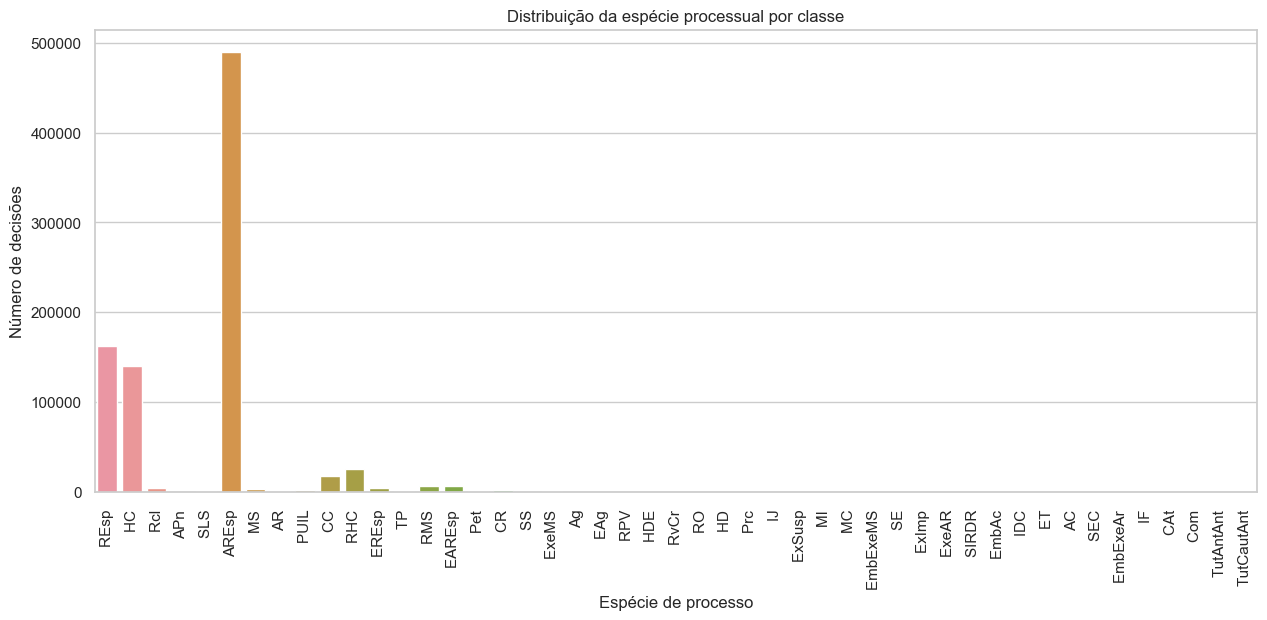

In [30]:
plt.figure(figsize=(15, 6))  # Adjust the width and height as needed
ax = sns.countplot(data=df, x='especieProcesso')
plt.xlabel('Espécie de processo')
plt.ylabel('Número de decisões')
plt.title('Distribuição da espécie processual por classe')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.show()

Como se observar, os Agravos em Recurso Especial (AREsp) são a classe predominante, seguida de Recursos Especiais (REsp) e *Habeas Corpus* (HC).

Considerando o número de decisões, apesar do AREsp ser predominante, iremos focar nos REsps por terem mais variabilidade de dados e número suficiente para uma filtragem.

In [31]:
mask = df['especieProcesso'] == 'REsp '
df_REsp = df[mask].copy()
df_REsp.drop('especieProcesso', axis=1, inplace=True)
df_REsp.head()

,seqDocumento,dataPublicacao,isAcordao,numeroRegistro,numProcessoSTJ,dataRecebimento,dataDistribuicao,ministro,recurso,teor,descricaoMonocratica,assuntos
0,144948780,2022-02-09 23:00:00-03:00,1,202002151590,1890871,2020-08-24 00:00:00-03:00,2020-09-01 00:00:00-03:00,ASSUSETE MAGALHÃES,NaN,Concedendo,NaN,10254;10225;10254;10225
44,144998370,2022-02-13 23:00:00-03:00,1,202100936957,1959271,2021-03-30 00:00:00-03:00,2021-04-12 00:00:00-03:00,OG FERNANDES,NaN,Concedendo,NaN,10288;10288;10673;10673
60,140395973,2022-02-13 23:00:00-03:00,1,201401895544,1475609,2014-08-05 00:00:00-03:00,2014-08-22 00:00:00-03:00,RAUL ARAÚJO,AGRAVO INTERNO,Concedendo,NaN,10451
61,140395973,2022-02-13 23:00:00-03:00,1,201401895544,1475609,2014-08-05 00:00:00-03:00,2014-08-22 00:00:00-03:00,RAUL ARAÚJO,AGRAVO INTERNO,Concedendo,NaN,10451
62,140395973,2022-02-13 23:00:00-03:00,1,201401895544,1475609,2014-08-05 00:00:00-03:00,2014-08-22 00:00:00-03:00,RAUL ARAÚJO,AGRAVO INTERNO,Concedendo,NaN,10451


In [32]:
df_REsp.shape

(162161, 12)

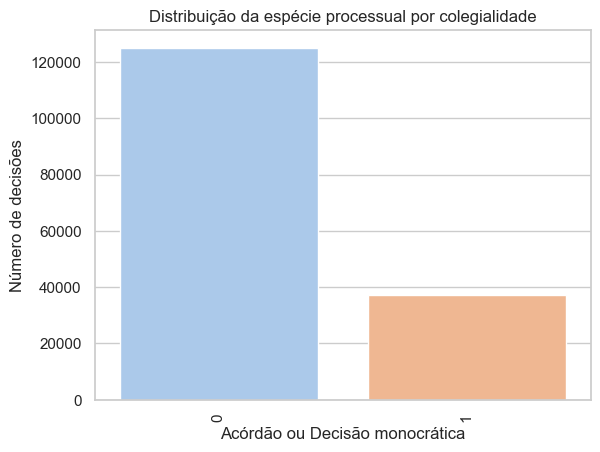

In [33]:
#plt.figure(figsize=(15, 6))
ax = sns.countplot(data=df_REsp, x='isAcordao')
plt.xlabel('Acórdão ou Decisão monocrática')
plt.ylabel('Número de decisões')
plt.title('Distribuição da espécie processual por colegialidade')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.show()

Observa-se que a maior parte das decisões são monocráticas, provavelmente concedendo ou negando em razão de jurisprudência consolidada.
Considerando-se que ainda é um número alto de decisões, iremos filtrar e selecionar apenas as decisões monocráticas (valor 0) para seguirmos na seleção de dados.

In [34]:
df_REsp = df_REsp.loc[df['isAcordao'] == 0].copy()
df_REsp.shape

(125045, 12)

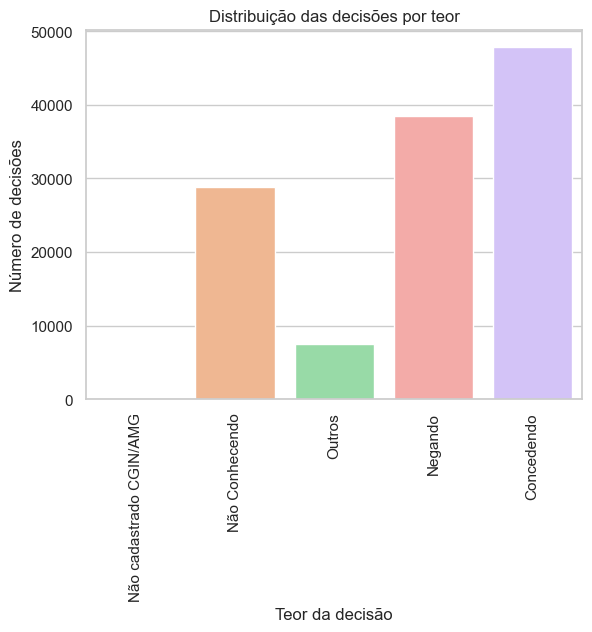

In [35]:
ax = sns.countplot(data=df_REsp, x='teor')
plt.xlabel('Teor da decisão')
plt.ylabel('Número de decisões')
plt.title('Distribuição das decisões por teor')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.show()

Como se observa, a maior parte das decisões é concedendo, negando ou não conhecendo o recurso.

Aqui já se extrai uma informação relevante para os operadores do direito: Uma vez que o recurso especial é admitido a chance de ser conhecido no mérito é maior do que se não admitido.

No que tange a esse trabalho, mesmo se limitando às decisões 'Concedendo' já temos um corpus bem relevante para treinamento, logo vamos focar nessa categoria.

In [36]:
df_REsp['teor'].unique()

array([nan, 'Não cadastrado CGIN/AMG', 'Não Conhecendo', 'Outros',
       'Negando', 'Concedendo'], dtype=object)

In [37]:
desired_value = 'Concedendo'
mask = df_REsp['teor'] == desired_value
df_REsp = df_REsp[mask].copy()
df_REsp.shape

(47826, 12)

In [38]:
df_REsp.reset_index(drop=True).to_feather('./backups/RESPs_todos_assuntos.feather')
#df_REsp = pd.read_feather('./backups/RESPs_todos_assuntos.feather')

Por último, os assuntos precisam ser organizados. Esses assuntos estão disponíveis para consulta no [site do CNJ](https://www.cnj.jus.br/sgt/consulta_publica_assuntos.php), mas também são disponibilizados para download num arquivo .csv. Como essa tabela possui grande granularidade (mais de 4700 assuntos disponíveis), vamos agrupar decisões em dois grandes grupos: Direito Civil e Direito Penal, ignorando demais temas.
Para evitar que isso se tranforme em um problema multilabel, decisões que abranjam ao mesmo tempo Direito Civil e Direito Penal serão excluidas também.

In [39]:
#Baixando o arquivo de assuntos
urllib.request.urlretrieve('https://dpj.cnj.jus.br/sgt/api/v1.0/assuntos.csv', 'assuntos.csv')

('assuntos.csv', <http.client.HTTPMessage at 0x1fa3b1cd5d0>)

In [40]:
#Carregando o arquivo
assuntos = pd.read_csv('assuntos.csv', encoding='utf-8', delimiter=';')
assuntos.shape

(5358, 7)

In [41]:
assuntos.head()

,situacao,dat_alteracao,codigo,descricao,cod_pai,cod_filhos,cod_filhos_ativos
0,A,2023-03-31 13:51:20,14101,(Fato até 10/01/2023) Injúria Preconceituosa e...,12543.0,NaN,NaN
1,A,2023-03-31 13:43:28,14102,(Fato até 10/01/2023) Injúria Preconceituosa e...,12543.0,NaN,NaN
2,A,2023-03-31 13:57:58,14103,(Fato até 10/01/2023) Injúria Preconceituosa e...,12543.0,NaN,NaN
3,A,NaN,14104,Condição de Pessoa Idosa,12543.0,NaN,NaN
4,A,NaN,14105,Condição de Pessoa Portadora de Deficiência,12543.0,NaN,NaN


In [42]:
#Removendo assuntos inativos
assuntos.drop((assuntos[assuntos['situacao'] == 'I'].index), inplace = True)
assuntos.shape

(4726, 7)

In [43]:
#Mostrando códigos de direito civil
codigos_civil = assuntos[assuntos['descricao'] == 'DIREITO CIVIL']['codigo'].tolist()
codigos_civil += assuntos[assuntos['descricao'] == 'DIREITO CIVIL']['cod_filhos'].tolist()
codigos_civil += assuntos[assuntos['descricao'] == 'DIREITO CIVIL']['cod_filhos_ativos'].tolist()
assuntos[assuntos['descricao'] == 'DIREITO CIVIL']

,situacao,dat_alteracao,codigo,descricao,cod_pai,cod_filhos,cod_filhos_ativos
508,A,NaN,899,DIREITO CIVIL,NaN,"5626,5754,7673,7681,7947,9616,9981,10431,10432...","5626,5754,7673,7681,7947,9616,9981,10431,10432..."


In [44]:
#Mostrando códigos de direito penal
codigos_penal = assuntos[assuntos['descricao'] == 'DIREITO PENAL']['codigo'].tolist()
codigos_penal += assuntos[assuntos['descricao'] == 'DIREITO PENAL']['cod_filhos'].tolist()
codigos_penal += assuntos[assuntos['descricao'] == 'DIREITO PENAL']['cod_filhos_ativos'].tolist()
assuntos[assuntos['descricao'] == 'DIREITO PENAL']

,situacao,dat_alteracao,codigo,descricao,cod_pai,cod_filhos,cod_filhos_ativos
506,A,NaN,287,DIREITO PENAL,NaN,"3369,3385,3388,3393,3394,3400,3405,3407,3412,3...","3369,3385,3388,3393,3394,3400,3405,3407,3412,3..."


In [45]:
#Aninhando as listas para desempacotar
codigos_civil[1] = codigos_civil[1].split(',')
codigos_civil[2] = codigos_civil[2].split(',')
codigos_penal[1] = codigos_penal[1].split(',')
codigos_penal[2] = codigos_penal[2].split(',')

In [46]:
#Função para desempacotar lista aninhada
def unpack_and_convert(nested_list):
    result = []
    for item in nested_list:
        if isinstance(item, list):
            result.extend(unpack_and_convert(item))
        else:
            result.append(int(item))
    return result

In [47]:
#Desempacota e itera sobre os números em um conjunto, evitando números repetidos
codigos_civil = list(set(unpack_and_convert(codigos_civil)))
codigos_penal = list(set(unpack_and_convert(codigos_penal)))

In [48]:
print(codigos_civil)

[6238, 6239, 12383, 10431, 10432, 10433, 10434, 10435, 10436, 10437, 10439, 10440, 10441, 10442, 10443, 10444, 10445, 10446, 10447, 10448, 10449, 10450, 10451, 10452, 10453, 10454, 10455, 10456, 10457, 10458, 10459, 10460, 10461, 10462, 10463, 10464, 10465, 10466, 10467, 10468, 10469, 10470, 10480, 10481, 10482, 10483, 10484, 10485, 10486, 10487, 10488, 10489, 10490, 10491, 10492, 10493, 10494, 10495, 10496, 10499, 10500, 10501, 10577, 10582, 10585, 10586, 10588, 10590, 10592, 10595, 14694, 14735, 14740, 14743, 4654, 4656, 4660, 4670, 14915, 14916, 14917, 14918, 14919, 14920, 14921, 14922, 14923, 14924, 4680, 4701, 4703, 4706, 10855, 4718, 4728, 12935, 12937, 10924, 12980, 10936, 4794, 10948, 4805, 15046, 15047, 4813, 4839, 4840, 4841, 4842, 4843, 4846, 15087, 15088, 4847, 4854, 11000, 11001, 13055, 4897, 4899, 4902, 4904, 4905, 4907, 4909, 4910, 13124, 15173, 4933, 4934, 4935, 4939, 4940, 4942, 4943, 13136, 15189, 4949, 4951, 4957, 4960, 4961, 4962, 4963, 4964, 13153, 4968, 4969, 4970

In [49]:
print(codigos_penal)

[12333, 12334, 12335, 12336, 12337, 12338, 12339, 12340, 12342, 12343, 12344, 12345, 12346, 12347, 12348, 12349, 12350, 12351, 12352, 12353, 12354, 12355, 12356, 12397, 12398, 12542, 12543, 12544, 10508, 10509, 10514, 10515, 10516, 10523, 287, 12588, 14659, 14660, 14661, 14662, 14663, 14664, 14665, 14666, 14667, 14668, 14669, 14670, 14684, 14685, 14689, 14690, 14692, 14697, 14698, 14703, 14704, 14705, 14706, 10612, 10613, 10614, 10615, 10616, 10617, 10618, 10619, 10620, 10621, 10622, 10623, 10624, 10625, 10626, 10627, 10628, 10633, 10634, 14731, 10642, 10643, 10644, 14779, 14780, 14781, 14782, 14783, 14784, 14785, 14786, 14787, 14788, 14789, 14790, 14791, 14792, 14793, 14794, 14795, 14796, 14797, 14798, 14799, 14800, 14801, 14802, 14803, 14804, 14805, 12772, 12773, 12774, 10747, 10748, 10749, 10750, 10751, 10752, 10753, 10754, 10755, 10756, 10815, 10816, 10817, 10818, 10819, 10820, 10821, 10822, 10823, 10824, 10825, 10826, 10827, 10830, 10831, 10832, 10833, 10834, 10835, 10836, 10837, 

In [50]:
#Verificando se por acaso alguma alteração deixou algum assunto em comum (no caso de ter ocorrido atualização de assuntos ao longo do tempo)
set1 = set(codigos_civil)
set2 = set(codigos_penal)
print(f'Número de assuntos em comum entre o conjunto de direito civil e o de direito penal: {len(set1.intersection(set2))}.')

Número de assuntos em comum entre o conjunto de direito civil e o de direito penal: 0.


In [51]:
#Criando uma função para iterar sobre o campo 'assuntos' e gerar uma lista com os assuntos nele contidos
def listaAssuntos(campo):
    assunto = campo.split(';')
    lista_assuntos_str = set(assunto)
    list_assuntos = []
    for i in lista_assuntos_str:
        list_assuntos.append(int(i))
    return list_assuntos

In [52]:
#Aplicando a função acima ao dataset para permitir a classificação por assuntos
df_REsp['assuntos'] = df_REsp['assuntos'].apply(listaAssuntos)
df_REsp['assuntos']

53992                       [10395]
54081                 [3608, 10621]
54159          [3548, 10621, 10628]
54160     [9163, 11806, 9607, 4960]
54203                       [10318]
                    ...            
866912           [5946, 9532, 6001]
866913          [5986, 6017, 13250]
866914          [5986, 6017, 13250]
866915                       [3608]
866917                       [6226]
Name: assuntos, Length: 47826, dtype: object

In [53]:
type(df_REsp.iloc[0]['assuntos'][0])

int

In [54]:
#Marcando as decisões que são de temas de civil
df_REsp['assuntoCivil'] = df_REsp['assuntos'].apply(lambda x: 1 if any(item in x for item in codigos_civil) else 0)
df_REsp['assuntoCivil'].sum()

10222

In [55]:
#Marcando as decisões que são de temas de penal
df_REsp['assuntoPenal'] = df_REsp['assuntos'].apply(lambda x: 1 if any(item in x for item in codigos_penal) else 0)
df_REsp['assuntoPenal'].sum()

6474

In [56]:
#Checanndo quantas decisões tratam ao mesmo tempo de assuntos civis e assuntos penais
print(f"O número de decisões que tratam ao mesmo tema de assuntos civis e penais é: {((df_REsp['assuntoCivil'] == 1) & (df_REsp['assuntoPenal'] == 1)).sum()}.")

O número de decisões que tratam ao mesmo tema de assuntos civis e penais é: 21.


In [57]:
#Checanndo quantas decisões não tratam de ambos os temas
print(f"O número de decisões que não trata de nenhum desses temas é: {((df_REsp['assuntoCivil'] == 0) & (df_REsp['assuntoPenal'] == 0)).sum()}.")

O número de decisões que não trata de nenhum desses temas é: 31151.


In [58]:
#Removendo decisões que não são desses temas ou que tratam de ambos os assuntos ao mesmo tempo
df_REsp = df_REsp.drop(df_REsp[(df_REsp['assuntoCivil'] == 0) & (df_REsp['assuntoPenal'] == 0)].index)
df_REsp = df_REsp.drop(df_REsp[(df_REsp['assuntoCivil'] == 1) & (df_REsp['assuntoPenal'] == 1)].index)
df_REsp.shape

(16654, 14)

In [59]:
#Verificando se os valores remanescente são necessariamente um OU outro (problema de classificação simples)
df_REsp.shape[0] == ((df_REsp['assuntoCivil'] == 1) ^ (df_REsp['assuntoPenal'] == 1)).sum()

True

In [60]:
df_REsp.head()

,seqDocumento,dataPublicacao,isAcordao,numeroRegistro,numProcessoSTJ,dataRecebimento,dataDistribuicao,ministro,recurso,teor,descricaoMonocratica,assuntos,assuntoCivil,assuntoPenal
54081,145978806,2022-02-23 00:00:00-03:00,0,202200406994,1985318,2022-02-14 23:00:00-03:00,2022-02-15 23:00:00-03:00,JESUÍNO RISSATO (DESEMBARGADOR CONVOCADO DO TJ...,NaN,Concedendo,Conhecido o recurso e provido,"[3608, 10621]",0,1
54159,146082236,2022-02-24 00:00:00-03:00,0,202200371266,1984564,2022-02-10 23:00:00-03:00,2022-02-17 23:00:00-03:00,REYNALDO SOARES DA FONSECA,NaN,Concedendo,Conhecido o recurso e provido,"[3548, 10621, 10628]",0,1
54160,145978085,2022-02-23 00:00:00-03:00,0,202200370584,1984559,2022-02-10 23:00:00-03:00,2022-02-21 00:00:00-03:00,MOURA RIBEIRO,NaN,Concedendo,Conhecido o recurso e provido,"[9163, 11806, 9607, 4960]",1,0
54237,145990515,2022-02-23 00:00:00-03:00,0,202200342399,1984357,2022-02-08 23:00:00-03:00,2022-02-21 00:00:00-03:00,NANCY ANDRIGHI,NaN,Concedendo,Conhecido o recurso e provido em parte,"[4964, 10880, 10945]",1,0
54266,145959512,2022-02-25 00:00:00-03:00,0,202200332669,1984248,2022-02-08 23:00:00-03:00,2022-02-10 23:00:00-03:00,JESUÍNO RISSATO (DESEMBARGADOR CONVOCADO DO TJ...,NaN,Concedendo,Conhecido o recurso e provido em parte,"[5566, 5555]",0,1


In [61]:
#Alguns valores podem ser eliminados. Teor será sempre concedendo.
#Os assuntos relevantes já foram filtrados, então não são mais necessários.
#'assuntoCivil' também pode ser eliminado para evitar colinearidade, pois será civil se 'assuntoPenal' for 0
#isAcordao também é desnecessária pois só estamos trabalhando com acórdãos
df_REsp = df_REsp.drop(['teor', 'assuntoCivil', 'assuntos', 'isAcordao'], axis=1)
df_REsp.shape

(16654, 10)

In [62]:
#Salvando o dataset
df_REsp.to_csv('REsp_binario.csv', index=False)

In [63]:
#Carregando o dataset nesse estado
#df_REsp = pd.read_csv('REsp_binario.csv')
#df.head()

O campo 'recurso' indica se a decisão foi proferida em algum recurso interno ao REsp ou se foi no processo principal. Vamos verificar o quando representa do dataset.

In [64]:
print(f"Decisões proferidas em recursos internos são {df_REsp['recurso'].notna().sum()}. Elas correspondem a {format(((df_REsp['recurso'].notna().sum())/(df_REsp.shape[0])*100), '.2f')}% do dataset.")

Decisões proferidas em recursos internos são 1304. Elas correspondem a 7.83% do dataset.


In [65]:
#Mantendo apenas decisões com 'NaN' no campo recurso, pois se referem a decisões proferidas no processo principal.
df_REsp = df_REsp[df_REsp['recurso'].isna()]
df_REsp.shape

(15350, 10)

In [66]:
#Verificando o resultado
df_REsp['recurso'].unique()

array([nan], dtype=object)

In [67]:
#Coluna 'recurso' é desnecessária agora
df_REsp = df_REsp.drop('recurso', axis=1)

In [68]:
#Verificando a descrição das decisões
df_REsp['descricaoMonocratica'].unique()

array(['Conhecido o recurso e provido',
       'Conhecido o recurso e provido em parte',
       'Conhecido em parte o recurso e provido',
       'Conhecido em parte o recurso e provido em parte',
       'Agravo conhecido para dar parcial provimento ao Recurso Especial\r\n',
       'Concedido o Habeas Corpus',
       'Agravo conhecido para dar provimento ao Recurso Especial\r\n',
       'Determinar re-autuação como Recurso Especial\r\n',
       'Embargos de Declaração Acolhidos',
       'Agravo conhecido para conhecer do Recurso Especial\r\n',
       'Deferido o pedido\r\n\r\n\r\n',
       'Agravo conhecido em parte para dar provimento ao Recurso Especial\r\n',
       'Embargos de Declaração Acolhidos em Parte',
       'Não conhecido o Habeas Corpus. Concedido o Habeas Corpus  de ofício.',
       'Provimento por decisão monocrática',
       'Agravo conhecido em parte para conhecer em parte o recurso especial e dar provimento\r\n',
       'Concedida a ordem',
       'Agravo conhecido em 

In [69]:
#Formatando para apresentação dos dados em gráfico
df_REsp['descricaoMonocratica'] = df_REsp['descricaoMonocratica'].str.replace('\r|\n', '', regex=True)

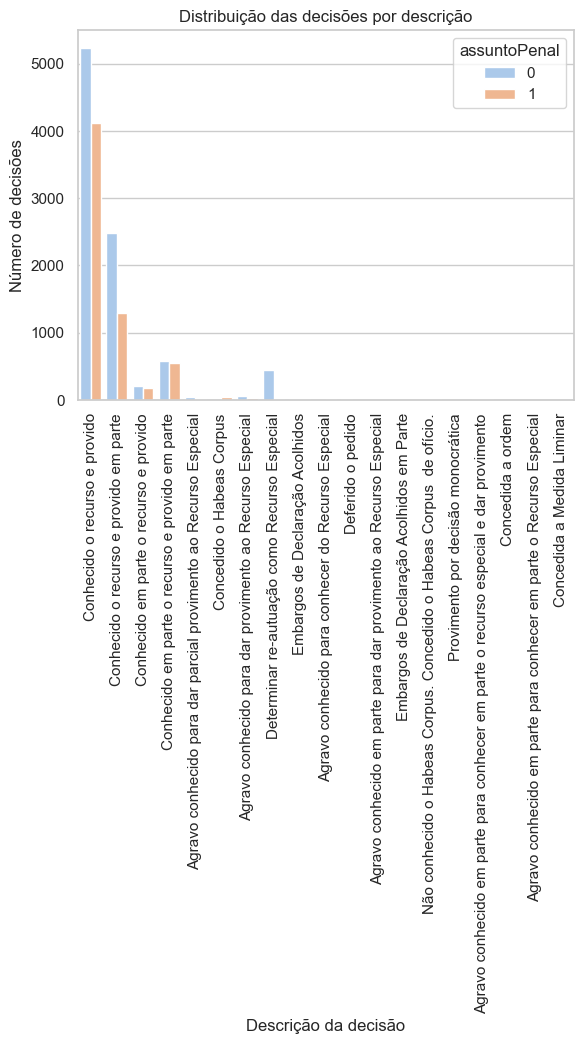

In [70]:
#Plotando a descrição das decisões
ax = sns.countplot(data=df_REsp, x='descricaoMonocratica', hue='assuntoPenal')
plt.xlabel('Descrição da decisão')
plt.ylabel('Número de decisões')
plt.title('Distribuição das decisões por descrição')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.show()

O dataset ainda apresenta quantidade significativa de dados, sendo que a maior parte são de recursos que foram conhecidos e providos integralmente.
Esse grupo contém boas quantidades de decisões civis e penais, logo podemos nos restringir a essas decisões e ainda teremos dados de sobra para o treinamento.

In [71]:
#Mantendo apenas recursos que foram conhecidos integralmente e providos integralmente
df_REsp = df_REsp[df_REsp['descricaoMonocratica'] == 'Conhecido o recurso e provido']
df_REsp = df_REsp.drop('descricaoMonocratica', axis=1)
df_REsp.shape

(9356, 8)

In [72]:
df_REsp['ministro'].unique()

array(['JESUÍNO RISSATO (DESEMBARGADOR CONVOCADO DO TJDFT)',
       'REYNALDO SOARES DA FONSECA', 'MOURA RIBEIRO',
       'SEBASTIÃO REIS JÚNIOR', 'JOEL ILAN PACIORNIK',
       'MARCO AURÉLIO BELLIZZE', 'ANTONIO SALDANHA PALHEIRO',
       'ROGERIO SCHIETTI CRUZ', 'LAURITA VAZ', 'OG FERNANDES',
       'ANTONIO CARLOS FERREIRA',
       'OLINDO MENEZES (DESEMBARGADOR CONVOCADO DO TRF 1ª REGIÃO)',
       'LUIS FELIPE SALOMÃO', 'JOÃO OTÁVIO DE NORONHA', 'NANCY ANDRIGHI',
       'PAULO DE TARSO SANSEVERINO', 'MARCO BUZZI',
       'RICARDO VILLAS BÔAS CUEVA', 'RIBEIRO DANTAS', 'HERMAN BENJAMIN',
       'MARIA ISABEL GALLOTTI', 'RAUL ARAÚJO', 'REGINA HELENA COSTA',
       'MANOEL ERHARDT (DESEMBARGADOR CONVOCADO DO TRF5)',
       'FRANCISCO FALCÃO', 'SÉRGIO KUKINA', 'GURGEL DE FARIA',
       'MAURO CAMPBELL MARQUES', 'BENEDITO GONÇALVES',
       'ASSUSETE MAGALHÃES', 'JORGE MUSSI', 'MESSOD AZULAY NETO',
       'JOÃO BATISTA MOREIRA  (DESEMBARGADOR CONVOCADO DO TRF1)',
       'HUMBERTO MARTINS'

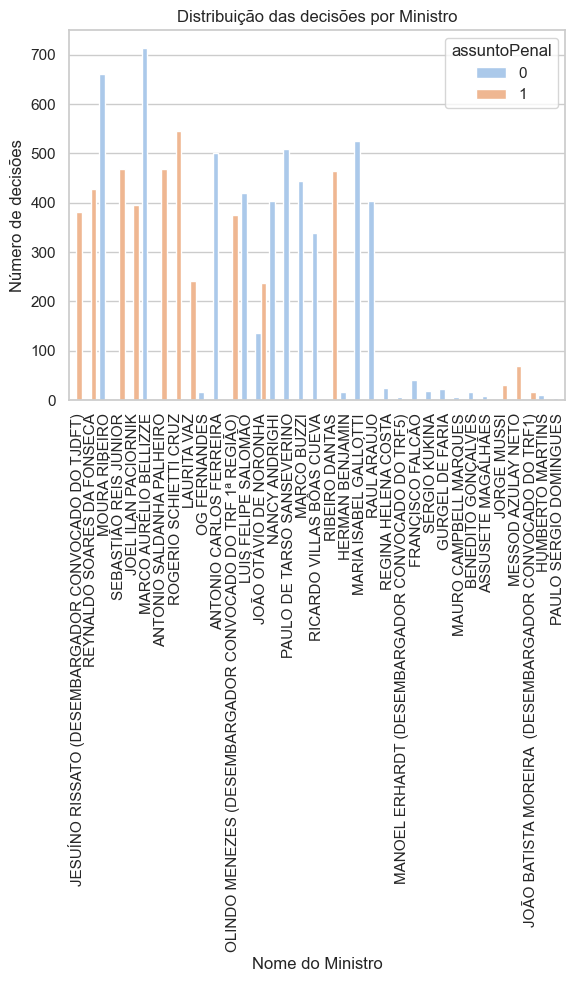

In [73]:
#Plotando o número de decisões por Ministro
ax = sns.countplot(data=df_REsp, x='ministro', hue='assuntoPenal')
plt.xlabel('Nome do Ministro')
plt.ylabel('Número de decisões')
plt.title('Distribuição das decisões por Ministro')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.show()

Observa-se que grande parte das decisões foram proferidas por poucos ministros, tendo outros proferidos relativamente poucas decisões sobre os temas.
Uma das explicações é a divisão de matérias dos STJ. Existem alguns ministros com especializações diferentes e sesções também.

A organização do STJ atual é a seguinte:

| Matéria​ | Exemplos | Seção | Turmas | 
| --- | --- | --- | --- |
| Direito público | Impostos, previdência, servidores públicos, indenizações do Estado, improbidade | Primeira | Primeira e Segunda | 
| Direito privado | Comércio, consumo, contratos, família, sucessões | Segunda | Terceira e Quarta |
| Direito penal | Crimes em geral, federalização de crimes contra direitos humanos | Terceira | Quinta e Sexta |

Sendo assim, uma das hipóteses é que os ministros com poucas decisões pertençam à Primeira Seção e são decisões que lidam com Direito Público e apenas tangencialmente tratam de assuntos de direito civil ou de direito penal, explicando a pequena quantidade de decisões.

De qualquer maneira, há dados suficientes para testes nos ministros com mais decisões e filtrar as desses provavelmente elimina ruídos desnecessários, considerando que cada Ministro possui seu estilo de redação e pode se tratar de assuntos diversos, que dificultariam o aprendizado pelo modelo.

In [74]:
#Selecionando Ministros que contam com menos de 100 decisões nesse dataset
num_decisoes = df_REsp['ministro'].value_counts()
lista_ministros = num_decisoes[num_decisoes < 100].index.tolist()
lista_ministros

['MESSOD AZULAY NETO',
 'FRANCISCO FALCÃO',
 'JORGE MUSSI',
 'REGINA HELENA COSTA',
 'GURGEL DE FARIA',
 'SÉRGIO KUKINA',
 'BENEDITO GONÇALVES',
 'JOÃO BATISTA MOREIRA  (DESEMBARGADOR CONVOCADO DO TRF1)',
 'HERMAN BENJAMIN',
 'OG FERNANDES',
 'HUMBERTO MARTINS',
 'ASSUSETE MAGALHÃES',
 'MANOEL ERHARDT (DESEMBARGADOR CONVOCADO DO TRF5)',
 'MAURO CAMPBELL MARQUES',
 'PAULO SÉRGIO DOMINGUES']

In [75]:
#Removendo decisões desses ministros
df_REsp = df_REsp[~df_REsp['ministro'].isin(lista_ministros)]
df_REsp.shape

(9057, 8)

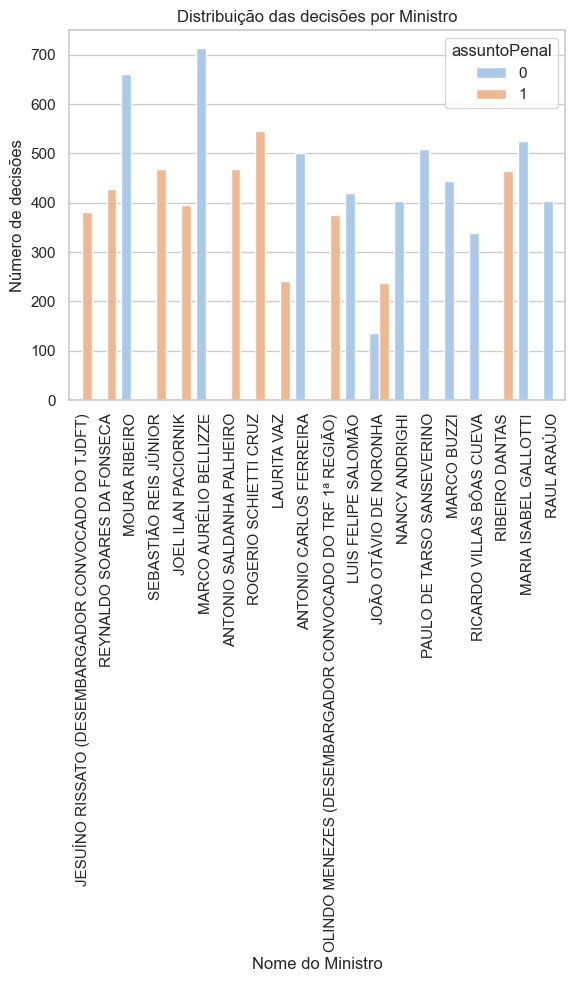

In [76]:
#Plotando o número de decisões por Ministro
ax = sns.countplot(data=df_REsp, x='ministro', hue='assuntoPenal')
plt.xlabel('Nome do Ministro')
plt.ylabel('Número de decisões')
plt.title('Distribuição das decisões por Ministro')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.show()

In [77]:
df_REsp.head()

,seqDocumento,dataPublicacao,numeroRegistro,numProcessoSTJ,dataRecebimento,dataDistribuicao,ministro,assuntoPenal
54081,145978806,2022-02-23 00:00:00-03:00,202200406994,1985318,2022-02-14 23:00:00-03:00,2022-02-15 23:00:00-03:00,JESUÍNO RISSATO (DESEMBARGADOR CONVOCADO DO TJ...,1
54159,146082236,2022-02-24 00:00:00-03:00,202200371266,1984564,2022-02-10 23:00:00-03:00,2022-02-17 23:00:00-03:00,REYNALDO SOARES DA FONSECA,1
54160,145978085,2022-02-23 00:00:00-03:00,202200370584,1984559,2022-02-10 23:00:00-03:00,2022-02-21 00:00:00-03:00,MOURA RIBEIRO,0
54303,146238111,2022-02-25 00:00:00-03:00,202200345267,1984373,2022-02-09 23:00:00-03:00,2022-02-17 23:00:00-03:00,REYNALDO SOARES DA FONSECA,1
54305,146152110,2022-02-24 00:00:00-03:00,202200343829,1984364,2022-02-08 23:00:00-03:00,2022-02-15 23:00:00-03:00,SEBASTIÃO REIS JÚNIOR,1


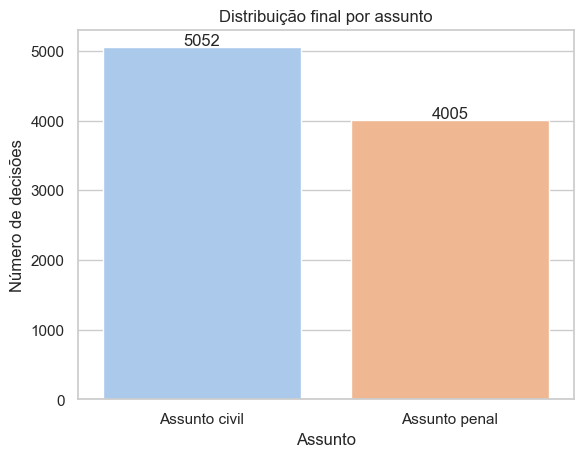

In [78]:
#Plotando distribuição final dos resultados
ax = sns.countplot(data=df_REsp, x='assuntoPenal')
plt.xlabel('Assunto')
plt.ylabel('Número de decisões')
plt.title('Distribuição final por assunto')
ax.set_xticklabels(['Assunto civil', 'Assunto penal'])
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

O problema está levemente desbalanceado mas ainda temos bastante dados, considerando que as decisões possuem bastante texto.
Iremos limitar à 200 decisões de cada classe, das mais recentes às mais antigas, considerando que é um problema complexo.

In [79]:
casos_Civil = df_REsp.copy()
casos_Civil = casos_Civil.sort_values(by='dataPublicacao', ascending=False, ignore_index=True)
casos_Civil = casos_Civil[casos_Civil['assuntoPenal'] == 0].head(200)
casos_Civil.shape

(200, 8)

In [80]:
casos_Civil['assuntoPenal'].sum()

0

In [81]:
casos_Penal = df_REsp.copy()
casos_Penal = casos_Penal.sort_values(by='dataPublicacao', ascending=False, ignore_index=True)
casos_Penal = casos_Penal[casos_Penal['assuntoPenal'] == 1].head(200)
casos_Penal.shape

(200, 8)

In [82]:
casos_Penal['assuntoPenal'].sum()

200

In [83]:
df_select = pd.concat([casos_Civil, casos_Penal], axis=0)
df_select = df_select.sort_values(by='dataPublicacao', ascending=False, ignore_index=True)
df_select.head()

,seqDocumento,dataPublicacao,numeroRegistro,numProcessoSTJ,dataRecebimento,dataDistribuicao,ministro,assuntoPenal
0,192865312,2023-06-06 00:00:00-03:00,202301647285,2075400,2023-05-17 00:00:00-03:00,2023-06-02 00:00:00-03:00,MARCO AURÉLIO BELLIZZE,0
1,192855731,2023-06-06 00:00:00-03:00,202301168720,2064109,2023-04-11 00:00:00-03:00,2023-04-26 00:00:00-03:00,MOURA RIBEIRO,0
2,192537192,2023-06-06 00:00:00-03:00,202301578950,2070820,2023-05-12 00:00:00-03:00,2023-05-25 00:00:00-03:00,RIBEIRO DANTAS,1
3,192568047,2023-06-06 00:00:00-03:00,202300792357,2058101,2023-03-13 00:00:00-03:00,2023-03-22 00:00:00-03:00,RIBEIRO DANTAS,1
4,192736856,2023-06-06 00:00:00-03:00,202300955419,2061976,2023-03-23 00:00:00-03:00,2023-04-11 00:00:00-03:00,RIBEIRO DANTAS,1


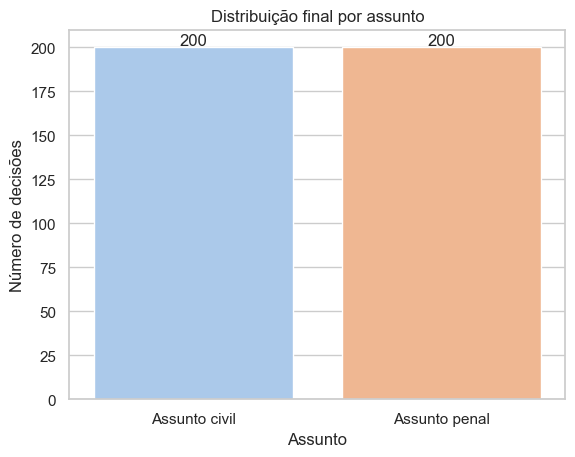

In [84]:
#Verificando dataset final
#Plotando distribuição final dos resultados
ax = sns.countplot(data=df_select, x='assuntoPenal')
plt.xlabel('Assunto')
plt.ylabel('Número de decisões')
plt.title('Distribuição final por assunto')
ax.set_xticklabels(['Assunto civil', 'Assunto penal'])
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

O dataset está plenamente equilibrado (como todas as coisas devem ser).

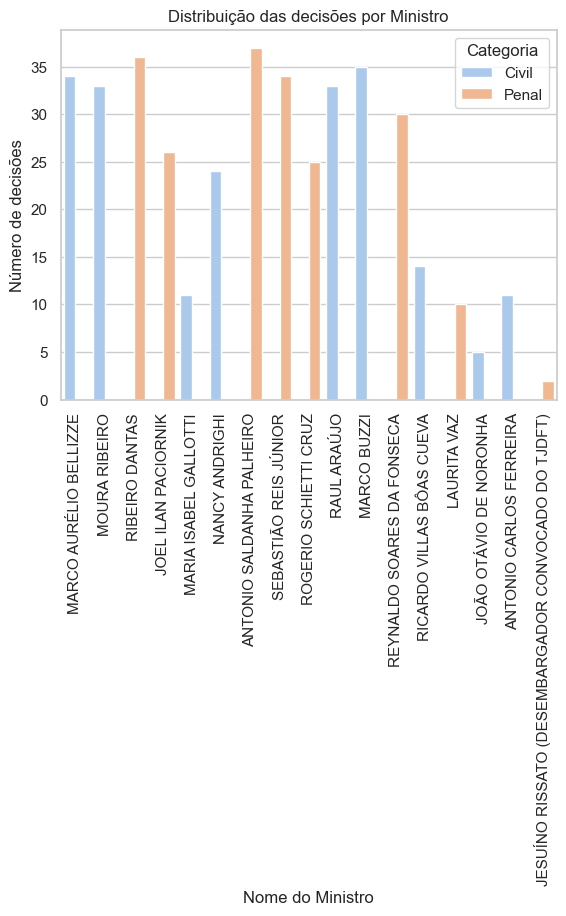

In [85]:
#Plotando o número de decisões por Ministro
ax = sns.countplot(data=df_select, x='ministro', hue='assuntoPenal')
plt.xlabel('Nome do Ministro')
plt.ylabel('Número de decisões')
plt.title('Distribuição das decisões por Ministro')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.legend(title='Categoria', labels=['Civil', 'Penal'])
plt.show()

O dataset está pronto para ser populado com os dados das decisões.

In [86]:
#Salvando o arquivo em .feather para preservar os tipos de dados do dataframe
df_select.reset_index(drop=True).to_feather('df_select.feather')

Em resumo, filtramos as decisões da seguinte maneira:

* Classificamos e selecionamos apenas os Recursos Especiais;
* Dessas decisões selecionamos apenas decisões monocráticas em Recursos Especiais;
* Dessas decisões selecionamos apenas aquelas que concederam (deram provimento) aos recursos;
* Organizamos os assuntos dessas decisões agrupamos as decisões em processos de Direito Civil e Direito Penal, excluindo os memais assuntos e processos que figuram em ambos (deixando um problema single label);
* Destes recursos selecionamos apenas aqueles que figuram em processo originários (isso é, julga o processo principal, não recursos agrupados);
* Destes recursos selecionamos apenas que possuem teor de total conhecimento e provimento, isso é, o recurso está formalmente perfeito nos aspectos processuais e teve o pedido de mérito deferido;
* Excluímos decisões proferidas de Ministros com poucos processos. Isso se deu pois, da maneira como aplicamos nosso filtro, recursos foram selecionados mesmo que proveniente de outras seções. Remover esses Ministros serve para minimizar esse ruído.
* Ao final selecionamos os 200 recursos mais recentes de cada classe, tornando o problema balanceado.

### 4.4 Carregando os textos

In [87]:
df_texto = pd.read_feather('df_select.feather')

In [88]:
#Determinando uma função para carregar os textos da pasta dos arquivos extraídos
def load_files_from_folder(folder_path, filename_pattern):
    file_data = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(filename_pattern):
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'r', encoding="utf8") as file:
                        file_data = file.read()
                except Exception as e:
                    print(f"Error loading file {file_path}: {str(e)}")
    return file_data

In [89]:
#Testanado a função
load_files_from_folder('./original_data/extracted/', '188171027.txt')

'DECISÃO<br>Trata-se de recurso especial interposto pelo ZULEIDE APARECIDA BEZERRA com fundamento no art. 105, III, a e c, da Constituição Federal, contra acórdão do Tribunal Regional Federal da 4ª Região (Apelação n. 5002001-29.2017.4.04.7015) nos autos de ação indenizatória.<br>O julgado foi assim ementado (fl. 1.566):<br>CIVIL. PROCESSUAL. ADMINISTRATIVO. IMÓVEIS FINANCIADOS COM RECURSOS DO SISTEMA FINANCEIRO DA HABITAÇÃO. SEGURO. FCVS. APÓLICE PÚBLICA. CEF. LEGITIMIDADE. JUSTIÇA FEDERAL. COMPETÊNCIA. TEMA 1011 DO STF. VÍCIOS DE CONSTRUÇÃO. AUSÊNCIA DE COBERTURA SECURITÁRIA.<br>1. O STF pacificou a questão da legitimidade da CEF para figurar no polo processual em demandas envolvendo contrato de seguro vinculado à apólice pública, consoante trecho do voto do Relator Ministro Gilmar Mendes nos autos do RE 827996/PR: "Após 26.11.2010, é da Justiça Federal a competência para o processamento e julgamento das causas em que se discute contrato de seguro vinculado à apólice pública, na qual

In [90]:
#Testando a função
for i in df_texto['seqDocumento'].loc()[:5]:
    print(load_files_from_folder('./original_data/extracted/', str(i) + '.txt'))

DECISÃO<br>Cuida-se de recurso especial interposto por AURENI RODRIGUES DA SILVA NASCIMENTO E OUTRO contra o acórdão de fls. 265-269 (e-STJ), proferido pelo Tribunal Regional Federal da 5ª Região, assim ementado:<br>CIVIL. PROCESSUAL CIVIL. HIPOTECA SOBRE O IMÓVEL INSTITUÍDA PELA CONSTRUTORA JUNTO AO AGENTE FINANCEIRO. COMPRA E VENDA DE UNIDADE HABITACIONAL SEM A INTERVENIÊNCIA DA INSTITUIÇÃO FINANCEIRA. SÚMULA 308 DO STJ. NÃO APLICAÇÃO. . PROVIMENTO DO APELO DA CEF. DISTINGUISHING. PROVIMENTO DO APELO DA CEF.<br>Trata-se, na origem, de ação ordinária ajuizada em face da Caixa Econômica Federal, da BRAPOR - ENGENHARIA E CONSTRUÇÃO LTDA, da BRAMAIS INVESTIMENTOS IMOBILIÁRIOS LTDA e de JOSÉ AUGUSTO DE CAMPOS RODRIGUES E CASTRO, com vistas ao cancelamento do ônus hipotecário incidente sobre a unidade imobiliária indicada em favor do banco público;<br>O juízo a quo julgou procedentes os pedidos autorais, daí o apelo que se examina interposto pelo banco público;<br>Em suma, verifica-se que 

In [91]:
#Carregando os textos direto no dataset
for index, row in df_texto.iterrows():
    df_texto.at[index, 'texto'] = load_files_from_folder('./original_data/extracted/', str(row['seqDocumento']) + '.txt')

KeyboardInterrupt: 

In [ ]:
df_texto

In [ ]:
df_texto['texto'] = df_texto['texto'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x) #Necessário pois estava dando erro ao salvar em .feather
df_texto.reset_index(drop=True).to_feather('./dataset/df_texto.feather')

O arquivo está pronto para passar ao pré-processamento de texto.

## 5. Pre Processamento

In [10]:
df = pd.read_feather('./dataset/df_texto.feather')

In [11]:
df.isna().sum()

seqDocumento        0
dataPublicacao      0
numeroRegistro      0
numProcessoSTJ      0
dataRecebimento     0
dataDistribuicao    0
ministro            0
assuntoPenal        0
texto               0
dtype: int64

In [12]:
df.head()

,seqDocumento,dataPublicacao,numeroRegistro,numProcessoSTJ,dataRecebimento,dataDistribuicao,ministro,assuntoPenal,texto
0,188171027,2023-06-07 00:00:00-03:00,202300875199,2061110,2023-03-17 00:00:00-03:00,2023-04-20 00:00:00-03:00,JOÃO OTÁVIO DE NORONHA,0,DECISÃO<br>Trata-se de recurso especial interp...
1,188557049,2023-06-07 00:00:00-03:00,202301045813,2063252,2023-03-29 00:00:00-03:00,2023-04-20 00:00:00-03:00,JOÃO OTÁVIO DE NORONHA,0,DECISÃO<br>Trata-se de recurso especial interp...
2,189728877,2023-06-07 00:00:00-03:00,202301521564,2070105,2023-05-09 00:00:00-03:00,2023-05-12 00:00:00-03:00,REYNALDO SOARES DA FONSECA,1,DECISÃO<br>Trata-se de recurso especial interp...
3,192977397,2023-06-07 00:00:00-03:00,202301515393,2069966,2023-05-09 00:00:00-03:00,2023-05-17 00:00:00-03:00,ANTONIO SALDANHA PALHEIRO,1,DECISÃO<br>Trata-se de recurso especial interp...
4,192976623,2023-06-07 00:00:00-03:00,202301784225,2074405,2023-05-25 00:00:00-03:00,2023-05-26 00:00:00-03:00,REYNALDO SOARES DA FONSECA,1,DECISÃO<br>Trata-se de recurso especial interp...


In [13]:
#Retornando exemplo de texto
print(df.iloc[1]['texto'])

DECISÃO<br>Trata-se de recurso especial interposto pelo DANILO ALCANTARA DE OLIVEIRA com fundamento no art. 105, III, a e c, da Constituição Federal, contra acórdão do Tribunal de Justiça do Estado de São Paulo, em apelação, assim ementado (fl. 319):<br>APELAÇÃO. Compromisso de compra e venda de imóvel. Loteamento. Distrato por iniciativa da parte adquirente. Pedido de majoração do percentual a ser retido (de 20% para 25%). Impertinência. Restituição da comissão de corretagem paga pela construtora. Impertinência. Ausência de comprovação de que a construtora foi quem pagou a referida taxa. Direito de retenção dos valores pagos à título de IPTU. Possibilidade desde que seja comprovado o pagamento. Pretendida fixação da taxa de ocupação (razão do parcial provimento). Cabimento. Obrigação dos compradores de pagarem taxa de fruição mensal correspondente a 0,5% do valor do contrato, desde a imissão até a efetiva desocupação do bem, bem como eventuais débitos pendentes e incidentes sobre imóv

In [14]:
#Removendo tags <br> que incorporam no texto
df['texto'] = df['texto'].str.replace(r'<br>', ' ', regex=True)

In [15]:
#Carregando lista de stopwords em português
from nltk.corpus import stopwords
stop = stopwords.words('portuguese')
stopwords = [word for word in stop]
print(stopwords[:5]) #Mostrando exemplo de stopwords

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/home/ec2-user/nltk_data'
    - '/home/ec2-user/anaconda3/envs/python3/nltk_data'
    - '/home/ec2-user/anaconda3/envs/python3/share/nltk_data'
    - '/home/ec2-user/anaconda3/envs/python3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [98]:
#Carregando o snowball stemmer para fazer a radicalização de palavras(stemming)
from nltk.stem import SnowballStemmer
snow = SnowballStemmer('portuguese')

In [99]:
#Função para limpar as sentenças
def clean_sentence(sent):
    sent = sent.lower().strip()
    sent = re.sub('\s+', ' ', sent)
    sent = re.compile('<.*?>').sub('', sent)
    return sent

In [100]:
#Definindo função para processamento de texto
def process_text(text):
    final_text_list = []
    for sent in text:
        if not isinstance(sent, str):
            sent = ''
        sent = clean_sentence(sent)
        filtered_sentence = [snow.stem(w) for w in word_tokenize(sent) if (not w.isnumeric()) and (len(w) > 2) and (w not in stopwords)]
        final_string = " ".join(filtered_sentence)
        final_text_list.append(final_string)
    return final_text_list

In [101]:
#Processando o texto no dataset
df['procTexto'] = process_text(df['texto'])

In [102]:
#Exibindo exemplo de texto processado
print(df.iloc[0]['procTexto'])

decisã trata-s recurs especial interpost zuleid aparec bezerr fundament art iii constituiçã federal contr acórdã tribunal regional federal regiã apel 5002001-29.2017.4.04.7015 aut açã indenizatór julg assim ement 1.566 civil processual administr imóv financ recurs sistem financeir habit segur fcvs apólic públic cef legitim justic federal competent tem stf víci construçã ausênc cobertur securitár stf pacific questã legitim cef figur pol processual demand envolv contrat segur vincul apólic públic consoant trech vot relator ministr gilm mend aut 827996/pr após 26.11.2010 justic federal competent process julgament caus discut contrat segur vincul apólic públic cef atu defes fcvs dev desloc feit ram judiciári part moment refer empres públic federal uniã form espontân provoc indiqu inter interv caus observ art cpc e/ou art 1ºa lei12.409/2011 adem desnecessári aguard julgament embarg declar interpost aut dess recurs extraordinári conform precedent stj edcl resp 1524136/pr segur pod responsabi

In [103]:
#Removendo algumas expressões inúteis
df['procTexto'] = df['procTexto'].str.replace(r'julg \d{2}/\d{2}/\d{4}','', regex=True) #Remove data de julgamento de jurisprudência
df['procTexto'] = df['procTexto'].str.replace(r'dje \d{2}/\d{2}/\d{4}','', regex=True) #Remove data de publicação de jurisprudência
df['procTexto'] = df['procTexto'].str.replace(r'\d{7}-\d{2}\.\d{4}\.\d\.\d{2}\.\d{4}','',regex=True) #Remove números padrão CNJ
print(df.iloc[0]['procTexto'])

decisã trata-s recurs especial interpost zuleid aparec bezerr fundament art iii constituiçã federal contr acórdã tribunal regional federal regiã apel  aut açã indenizatór julg assim ement 1.566 civil processual administr imóv financ recurs sistem financeir habit segur fcvs apólic públic cef legitim justic federal competent tem stf víci construçã ausênc cobertur securitár stf pacific questã legitim cef figur pol processual demand envolv contrat segur vincul apólic públic consoant trech vot relator ministr gilm mend aut 827996/pr após 26.11.2010 justic federal competent process julgament caus discut contrat segur vincul apólic públic cef atu defes fcvs dev desloc feit ram judiciári part moment refer empres públic federal uniã form espontân provoc indiqu inter interv caus observ art cpc e/ou art 1ºa lei12.409/2011 adem desnecessári aguard julgament embarg declar interpost aut dess recurs extraordinári conform precedent stj edcl resp 1524136/pr segur pod responsabiliz repar víci construt i

In [104]:
#Salvando o dataset com o texto pré-processado
df_proc = df.copy()
df_proc.drop(columns=['seqDocumento', 'dataPublicacao', 'numeroRegistro', 'numProcessoSTJ','dataRecebimento', 'dataDistribuicao', 'ministro','texto'], inplace=True)
df_proc = df_proc.rename(columns={'assuntoPenal': 'target', 'procTexto': 'text'})
df_proc.to_csv('./dataset/text_proc.csv')

In [105]:
df_proc

,target,text
0,0,decisã trata-s recurs especial interpost zulei...
1,0,decisã trata-s recurs especial interpost danil...
2,1,decisã trata-s recurs especial interpost elo m...
3,1,decisã trata-s recurs especial interpost minis...
4,1,decisã trata-s recurs especial interpost danie...
...,...,...
395,1,decisã trata-s recurs especial interpost paul ...
396,1,decisã trata-s recurs especial interpost leona...
397,1,decisã trata-s recurs especial interpost rafae...
398,1,decisã trata-s recurs especial interpost enos ...


## 6. Processamento no SageMaker

In [133]:
#Carregando os módulos no sagemaker
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import urllib.request
import re
import nltk
from pprint import pprint
import os
import shutil
import re
import zipfile
import glob
from collections import Counter
from pytz import timezone
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings("ignore")

In [134]:
df = pd.read_csv('./dataset/text_proc.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df.head()
df.isna().sum()
df = df.dropna(how='any')
df.head()

,target,text
0,0,decisã trata-s recurs especial interpost zulei...
1,0,decisã trata-s recurs especial interpost danil...
2,1,decisã trata-s recurs especial interpost elo m...
3,1,decisã trata-s recurs especial interpost minis...
4,1,decisã trata-s recurs especial interpost danie...


Lembrando que, pela forma como dividimos o dataset, o 'target' será positivo se a decisão for de matéria penal. Ela será negativa se for de matéria civil.

In [135]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['target'], random_state=1216)

print(f"===> TRAIN\n{df_train['target'].value_counts() / df_train.shape[0]}\n")
print(f"===> TEST\n{df_test['target'].value_counts() / df_test.shape[0]}")

===> TRAIN
0    0.534722
1    0.465278
Name: target, dtype: float64

===> TEST
0    0.527778
1    0.472222
Name: target, dtype: float64


In [136]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

X_train = tfidf.fit_transform(df_train['text'])
y_train = df_train['target']

X_test = tfidf.transform(df_test['text'])
y_test = df_test['target']

In [137]:
X_train.shape, X_test.shape

((288, 10186), (72, 10186))

In [138]:
print(f'Vocabulary size: {len(tfidf.vocabulary_)}')

Vocabulary size: 10186


In [140]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight='balanced', n_jobs=-1)
logreg.fit(X_train, y_train)

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [141]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


InvalidParameterError: The 'type' parameter of Interval.__init__ must be an instance of 'type'. Got 'real_not_int' instead.

In [102]:
# prediction on training set
y_train_pred = logreg.predict(X_train)

In [103]:
from sklearn.metrics import classification_report

#print(classification_report(y_train, y_train_pred, target_names=target_names))
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       154
           1       1.00      1.00      1.00       134

    accuracy                           1.00       288
   macro avg       1.00      1.00      1.00       288
weighted avg       1.00      1.00      1.00       288



In [104]:
from sklearn.metrics import f1_score

f1_train = f1_score(y_train, y_train_pred, average='macro')

print(f'F1 Train: {f1_train}')

F1 Train: 1.0


In [105]:

from sklearn.metrics import balanced_accuracy_score

balacc_train = balanced_accuracy_score(y_train, y_train_pred)

print(f'Balanced Acc Train: {balacc_train}')

Balanced Acc Train: 1.0


In [106]:
# prediction on testing set
y_test_pred = logreg.predict(X_test)

In [107]:
#from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        34

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72



In [108]:
from sklearn.metrics import f1_score
f1_test = f1_score(y_test, y_test_pred, average='macro')
print(f'F1 Test: {f1_test}')

F1 Test: 1.0


In [116]:
tfidf_matrix = tfidf.fit_transform(df_train['text'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


In [118]:
tfidf_matrix

<288x10186 sparse matrix of type '<class 'numpy.float64'>'
	with 131436 stored elements in Compressed Sparse Row format>

In [119]:
avg_tfidf_scores = tfidf_matrix.mean(axis=0)

In [120]:
feature_names = vectorizer.get_feature_names()

AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names'

In [121]:
vectorizer = TfidfVectorizer()

# Fit the vectorizer on your corpus
tfidf_matrix = vectorizer.fit_transform(df_train['text'])

# Calculate the average TfIdf scores across all documents
avg_tfidf_scores = tfidf_matrix.mean(axis=0)

# Get the feature names
feature_names = vectorizer.get_feature_names()

# Get the indices of the top N features with the highest average TfIdf scores
top_n_indices = avg_tfidf_scores.argsort()[0, -N:]

# Get the corresponding feature names for the top N indices
top_n_features = [feature_names[idx] for idx in top_n_indices]

AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names'

In [122]:
feature_names = tfidf_vectorizer.get_feature_names()

NameError: name 'tfidf_vectorizer' is not defined

In [111]:
tfidf.mean()

AttributeError: 'TfidfVectorizer' object has no attribute 'mean'

In [110]:
# Create a TfIdf vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on your corpus
#tfidf_matrix = vectorizer.fit_transform(corpus)

# Calculate the average TfIdf scores across all documents
avg_tfidf_scores = tfidf_matrix.mean(axis=0)

# Get the feature names
feature_names = vectorizer.get_feature_names()

# Get the indices of the top N features with the highest average TfIdf scores
top_n_indices = avg_tfidf_scores.argsort()[0, -N:]

# Get the corresponding feature names for the top N indices
top_n_features = [feature_names[idx] for idx in top_n_indices]

NameError: name 'tfidf_matrix' is not defined

In [125]:
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 33.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.0
    Uninstalling scikit-learn-1.2.0:
      Successfully uninstalled scikit-learn-1.2.0


In [126]:
# Create an instance of the TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer on your corpus
tfidf_vectorizer.fit(df_train['text'])

# Get the feature names (terms)
feature_names = tfidf_vectorizer.get_feature_names()

# Get the IDF scores
idf_scores = tfidf_vectorizer.idf_

feature_scores = list(zip(feature_names, idf_scores))

feature_scores.sort(key=lambda x: x[1], reverse=True)

num_features = 10  # Number of top features to extract
top_features = feature_scores[:num_features]

for feature, score in top_features:
    print(feature, score)

AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names'

In [131]:
import operator

# Assuming you have already fit and transformed your data using TfidfVectorizer
# and stored the vectorizer in a variable called `tfidf_vectorizer`

# Access the vocabulary dictionary
vocabulary = tfidf_vectorizer.vocabulary_

# Sort the vocabulary based on the values (TF-IDF scores)
sorted_vocabulary = sorted(vocabulary.items(), key=operator.itemgetter(1))

# Print the sorted vocabulary
for feature, index in sorted_vocabulary:
    print(f"{feature}: {index}")

00: 0
000: 1
0000: 2
000047: 3
000149: 4
0002: 5
0002325: 6
000232553: 7
0004070: 8
0004168: 9
000479: 10
0008137: 11
0008514: 12
000962: 13
0009896: 14
001: 15
001058: 16
0014218: 17
001767: 18
0018: 19
001870: 20
002: 21
0021: 22
0023203: 23
0024: 24
002664: 25
0027: 26
003: 27
003010: 28
003251: 29
003261: 30
0034297: 31
003851: 32
004: 33
0040: 34
0041: 35
0041288: 36
004978: 37
005: 38
0051: 39
0054: 40
0056: 41
005686: 42
006: 43
007: 44
007600: 45
0077516: 46
008: 47
008397: 48
008514: 49
0086067: 50
008831: 51
008998: 52
009: 53
0090: 54
0099184: 55
01: 56
010: 57
0105: 58
0105386: 59
011: 60
0112: 61
012: 62
013: 63
013280: 64
014767: 65
015: 66
016: 67
017: 68
017240: 69
019: 70
019292: 71
0199184: 72
01kg: 73
02: 74
020: 75
021: 76
022: 77
022015: 78
023: 79
0230118: 80
0231: 81
023136: 82
024: 83
0245: 84
025: 85
026: 86
0260699: 87
0268890: 88
027: 89
028: 90
029: 91
02empreend: 92
02g: 93
03: 94
030: 95
031: 96
0313: 97
032: 98
033: 99
034: 100
035: 101
0358: 102
036: 103

In [130]:
import operator

# Assuming you have already fit and transformed your data using TfidfVectorizer
# and stored the vectorizer in a variable called `tfidf_vectorizer`

# Access the vocabulary dictionary
vocabulary = tfidf_vectorizer.vocabulary_

# Sort the vocabulary based on the values (TF-IDF scores) in descending order
sorted_vocabulary = sorted(vocabulary.items(), key=operator.itemgetter(1), reverse=True)

# Print the sorted vocabulary
for feature, index in sorted_vocabulary:
    print(f"{feature}: {index}")

ütu: 10185
útil: 10184
úte: 10183
únic: 10182
últim: 10181
ônussucumbenc: 10180
ônus: 10179
ônibus: 10178
óxi: 10177
ótim: 10176
ótic: 10175
órgã: 10174
ónus: 10173
óle: 10172
ócul: 10171
óbvi: 10170
óbit: 10169
óbic: 10168
ítal: 10167
írrit: 10166
íntim: 10165
íntegr: 10164
ínsit: 10163
ínfim: 10162
índol: 10161
índic: 10160
ícon: 10159
êxit: 10158
étic: 10157
ésuspens: 10156
époc: 10155
éimensur: 10154
égid: 10153
édit: 10152
çã: 10151
ânu: 10150
ângul: 10149
âmbit: 10148
âmag: 10147
áudio: 10146
áudi: 10145
átri: 10144
árvor: 10143
áre: 10142
álbuns: 10141
álbum: 10140
águ: 10139
àépoc: 10138
àspart: 10137
àquel: 10136
ºs: 10135
zuleid: 10134
zuccarell: 10133
zucarell: 10132
zon: 10131
zoldan: 10130
zit: 10129
zimm: 10128
zel: 10127
zavasck: 10126
zarzour: 10125
yur: 10124
yedd: 10123
xxxvii: 10122
xxv: 10121
xvii: 10120
xvi: 10119
xlvii: 10118
xlvi: 10117
xiv: 10116
xii: 10115
xerent: 10114
xbox: 10113
xavi: 10112
www: 10111
writ: 10110
would: 10109
world: 10108
wolff: 10107
wisnie

In [128]:
tfidf_vectorizer.vocabulary_

{'decisã': 3763,
 'trata': 9671,
 'recurs': 8423,
 'especial': 4753,
 'interpost': 6158,
 'charl': 2906,
 'lim': 6532,
 'sakrb': 8896,
 'xerent': 10114,
 'fundament': 5339,
 'art': 2296,
 'incis': 5845,
 'iii': 5677,
 'alín': 2000,
 'constituiçã': 3362,
 'federal': 5134,
 'contr': 3425,
 'acórdã': 1742,
 'prolat': 8050,
 'tribunal': 9699,
 'justic': 6384,
 'estad': 4797,
 'tocantins': 9584,
 'controvérs': 3467,
 'trat': 9670,
 'aut': 2429,
 'devid': 4141,
 'relat': 8538,
 'parec': 7466,
 'ministerial': 6880,
 'acost': 1720,
 'stj': 9254,
 'fls': 5235,
 '517': 1049,
 '520': 1053,
 'verb': 9920,
 'bas': 2530,
 'cf': 2898,
 '88': 1473,
 'tj': 9559,
 'to': 9578,
 'turm': 9732,
 'criminal': 3606,
 'neg': 7088,
 'proviment': 8131,
 'defes': 3810,
 'mant': 6711,
 'conden': 3222,
 'crim': 3601,
 'roub': 8848,
 'qualific': 8215,
 'recorrent': 8414,
 'primeir': 7958,
 'instânc': 6092,
 'pen': 7550,
 'anos': 2072,
 'quatr': 8233,
 'mes': 6847,
 'dias': 4169,
 'reclusã': 8387,
 'regim': 8490,
 'fe